In [1]:
import sys, time, cProfile, pstats, itertools
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 22, 'figure.figsize': (40, 8), 'font.family': 'serif', 'text.usetex': True, 'pgf.rcfonts': False})

%load_ext autoreload
%autoreload 2

sys.path.append('..')
import util
import Densities as de
import Forward as fw

plot_dir = open('plot.conf', 'r') .readlines()[0].rstrip()

# Basis

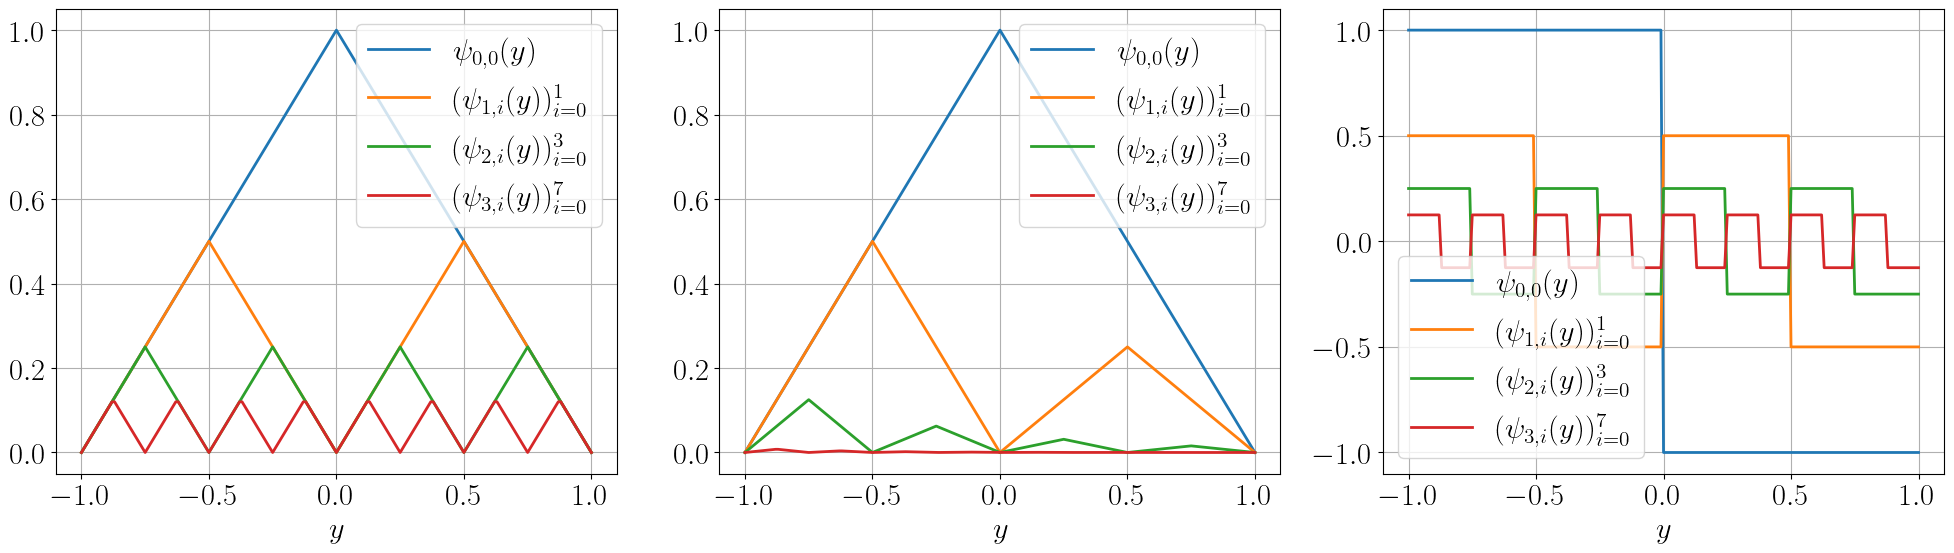

In [2]:
alpha = 1
x_eval = np.linspace(-1,1,201)
fig = plt.figure(figsize=(20,6))
for i,b in enumerate([util.basis.hats, util.basis.hats_cdec, util.basis.steps]) :
    ax = util.plot.get_ax(fig=fig, nx=3, ny=1, idx=i+1, xlabel=r'$y$')
    ax.plot(x_eval, [b(xi, [1], alpha=alpha) for xi in x_eval], lw=2, label=r'$\psi_{{0, 0}}(y)$')
    for l in range(1,4) :
        ax.plot(x_eval, [b(xi, [0] * (2**l - 1) + [1] * 2**l, alpha=alpha) for xi in x_eval], lw=2, label=r'$(\psi_{{ {}, i}}(y))_{{i=0}}^{{ {} }}$'.format(l,2**l-1))
    ax.legend()
plt.tight_layout()

In [3]:
tex = 0

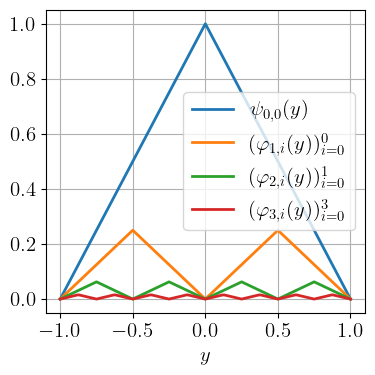

In [4]:
b = util.basis.hats
if tex : matplotlib.use('pgf')
else   : matplotlib.use('module://matplotlib_inline.backend_inline')
import matplotlib.pyplot as plt
matplotlib.rcParams.update({"font.family": "serif", 'font.size'  : 15, "text.usetex": True, "pgf.rcfonts": False})

alpha = 2
x_eval = np.linspace(-1,1,201)
ax1 = util.plot.get_ax(fig=plt.figure(figsize=(4,4)), xlabel=r'$y$')
ax1.plot(x_eval, [b(xi, [1], alpha=alpha) for xi in x_eval], lw=2, label=r'$\psi_{{0, 0}}(y)$')
for l in range(1,4) :
    ax1.plot(x_eval, [b(xi, [0] * (2**l - 1) + [1] * 2**l, alpha=alpha) for xi in x_eval], lw=2, label=r'$(\varphi_{{ {}, i}}(y))_{{i=0}}^{{ {} }}$'.format(l,2**(l-1)-1))
ax1.legend()
plt.tight_layout()
if tex : plt.savefig(plot_dir+'convolution_basis.pgf', format='pgf')
else   : plt.show()

# Signal function

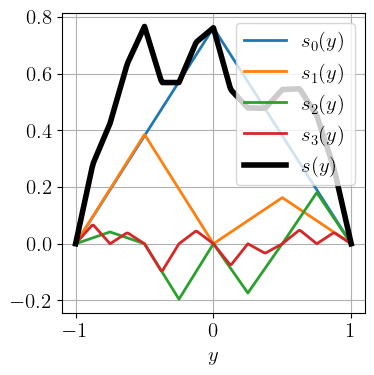

In [5]:
if tex : matplotlib.use('pgf')
else   : matplotlib.use('module://matplotlib_inline.backend_inline')
import matplotlib.pyplot as plt
matplotlib.rcParams.update({"font.family": "serif", 'font.size'  : 15, "text.usetex": True, "pgf.rcfonts": False})

d = 15
alpha = 1

if not tex : param = util.random.points(d)

ax = util.plot.get_ax(fig=plt.figure(figsize=(4,4)), xlabel=r'$y$')
for l in range(int(np.log2(d))+1) :
    ax.plot(x_eval, [b(xi, [0] * (2**l - 1) + list(param[2**l-1:2*2**l-1]), alpha=alpha) for xi in x_eval], lw=2, label=r'$s_{}(y)$'.format(l))
ax.plot(x_eval, [b(xi, param, alpha) for xi in x_eval], 'k', lw=4, label=r'$s(y)$')
ax.legend()
plt.tight_layout()
if tex : plt.savefig(plot_dir+'convolution_signal.pgf', format='pgf')
else   : plt.show()

# Convoluted Signal

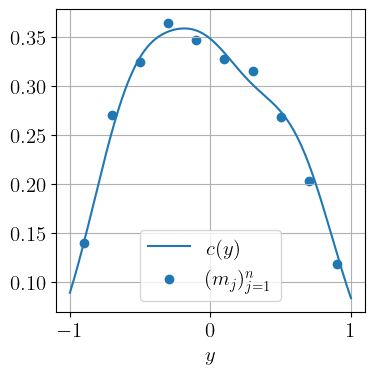

In [6]:
if tex : matplotlib.use('pgf')
else   : matplotlib.use('module://matplotlib_inline.backend_inline')
import matplotlib.pyplot as plt
matplotlib.rcParams.update({"font.family": "serif", 'font.size'  : 15, "text.usetex": True, "pgf.rcfonts": False})
matplotlib.rc('text', usetex=True)

noise = .02
chi = np.linspace(-.9,.9,10)
if not tex :
    f = fw.Convolution(basis=b, dim=d, alpha=alpha, xmeas=chi, save=False)
    m = f.eval(param) + noise*np.random.randn(len(chi),1)
    t = de.GaussianPosterior(forwd=f, truep=param, noise=noise, save=False)

F_x_meas = t.gauss.mean
F_x_eval = t.forwd.eval(param, xmeas=x_eval)

ax = util.plot.get_ax(fig=plt.figure(figsize=(4,4)), xlabel=r'$y$')#, title=r'$c(y)$ and $m$')
ax.plot(x_eval, F_x_eval, label=r'$c(y)$')
ax.scatter(chi, F_x_meas, label=r'$(m_j)_{j=1}^n$')

ax.legend()
plt.tight_layout()
if tex : plt.savefig(plot_dir+'convolution_measurement.pgf', format='pgf')
else   : plt.show()

# Convergence

In order to generate the data for the following plots, run `python scripts/runConvolution.py`.

In [7]:
import peewee as pw
DB = pw.SqliteDatabase('../data.db')

query_gauss = """
select {}
  from surrogateevaldbo as evl
  join surrogatedbo as sur
    on evl.surrog_id = sur.id
  join gaussianposteriordbo as tar 
    on sur.target_id = tar.id
   and sur.target = 'posterior'
   and sur.mode = '{}'
  join multiindexsetanisotropicdbo as mul
    on sur.multis_id = mul.id
  join convolutiondbo as fwd
    on tar.forwd_id = fwd.id
 where fwd.dim = {}
   and fwd.alpha = {}
   and tar.noise = {}
   and fwd.basis = '{}'
"""

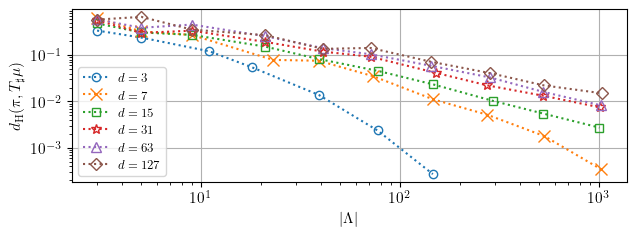

In [8]:
tex = 0
if tex : matplotlib.use('pgf')
else :   matplotlib.use('module://matplotlib_inline.backend_inline')
import matplotlib.pyplot as plt

alpha=2
noise=.1
ds=[3, 7, 15, 31, 63, 127]
mode='wls'
qoi='evl.hedist'
matplotlib.rcParams.update({'font.size': 11})
ax = util.plot.get_ax(fig=plt.figure(figsize=(6.5, 2.5)), xlabel=r'$|\Lambda|$', ylabel=r'$d_{\rm H}(\pi, T_\sharp \mu)$', logaxis=['x', 'y'])
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
markers = ['o', 'x', 's', '*', '^', 'D', 'x', 'v']
markersizes = [6,8,6,7,7,6]
for (i, d) in enumerate(ds) :
    cursor = DB.execute_sql(query_gauss.format('tar.id, mul.size, ' + qoi, mode, d, alpha, noise, 'hats'))
    col_names = [col[0] for col in cursor.description] 
    res = sorted([dict(zip(col_names, row)) for row in cursor.fetchall()], key=lambda x : x['id'])

    res2 = dict()
    for gk, g in itertools.groupby(res, lambda x : x['id']) :
        data = np.array([[r['size'], r[qoi.split('.')[1]]] for r in sorted(g, key=lambda x :  x['size']) if r[qoi.split('.')[1]] is not None and r[qoi.split('.')[1]] > 1e-4])
        for da in data :
            if da[0] not in res2.keys() : res2[da[0]] = [da[1]]
            else : res2[da[0]].append(da[1])

    keys = [k for k in sorted(res2.keys())]
    mean = [np.mean(res2[k]) for k in keys]
    ax.plot(keys, np.array(mean), c=cycle[i], 
            marker=markers[i], markerfacecolor='none', markersize=markersizes[i], 
            linestyle='dotted', label=r'$d={}$'.format(d))
ax.legend(prop={'size': 9})

plt.tight_layout()
if tex : plt.savefig(plot_dir+'convolution_error.pgf', format='pgf')
else :   plt.show()

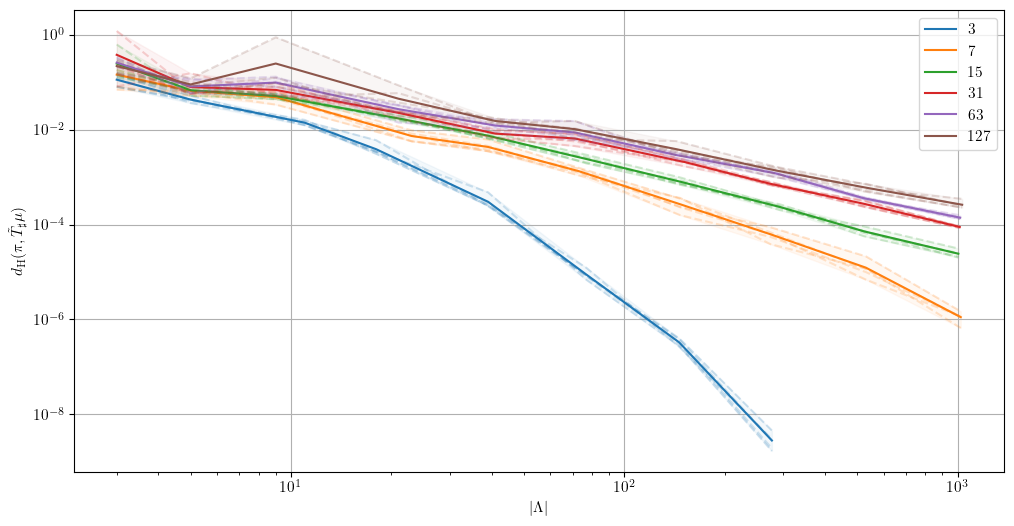

In [9]:
def plot_convolution_hedist_convergence_single(alpha=1, noise=.02, ds=[3, 7, 15, 31, 63, 127], mode='wls', qoi='evl.hedist', basis='hats', fig=None, nx=1, ny=1, idx=1, title='', verbose=False) :
    ax = util.plot.get_ax(fig=fig, nx=nx, ny=ny, idx=idx, xlabel=r'$|\Lambda|$', ylabel=r'$d_{\rm H}(\pi, \tilde{T}_\sharp \mu)$', title=title, logaxis=['x', 'y'])
    cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for (i, d) in enumerate(ds) :
        cursor = DB.execute_sql(query_gauss.format('tar.id, mul.size, ' + qoi, mode, d, alpha, noise, basis))
        col_names = [col[0] for col in cursor.description] 
        res = sorted([dict(zip(col_names, row)) for row in cursor.fetchall()], key=lambda x : x['id'])
        
        res2 = dict()
        for gk, g in itertools.groupby(res, lambda x : x['id']) :
            data = np.array([[r['size'], r[qoi.split('.')[1]]] for r in sorted(g, key=lambda x :  x['size']) if r[qoi.split('.')[1]] is not None])
            try :
                if len(data) > 0 :
                    plt.plot(data[:, 0], data[:, 1], c=cycle[i], ls='dashed', alpha=.2)
            except IndexError :
                print('error', d, data)

            for da in data :
                if da[0] not in res2.keys() : res2[da[0]] = [da[1]]
                else : res2[da[0]].append(da[1])

        if res2 :
            keys = [k for k in sorted(res2.keys())]
            if verbose : print(noise, alpha, [len(res2[k]) for k in keys])
            mean = [np.mean(res2[k]) for k in keys]
            minm = [np.min(res2[k]) for k in keys]
            maxm = [np.max(res2[k]) for k in keys]
            ax.plot(keys, np.array(mean), c=cycle[i], label=str(d))
            ax.fill_between(keys, minm, maxm, color=cycle[i], alpha=.05)
    ax.legend()

plot_convolution_hedist_convergence_single(alpha=2, noise=.5, ds=[3, 7, 15, 31,  63, 127], qoi='evl.hedist', fig=plt.figure(figsize=(12,6)))

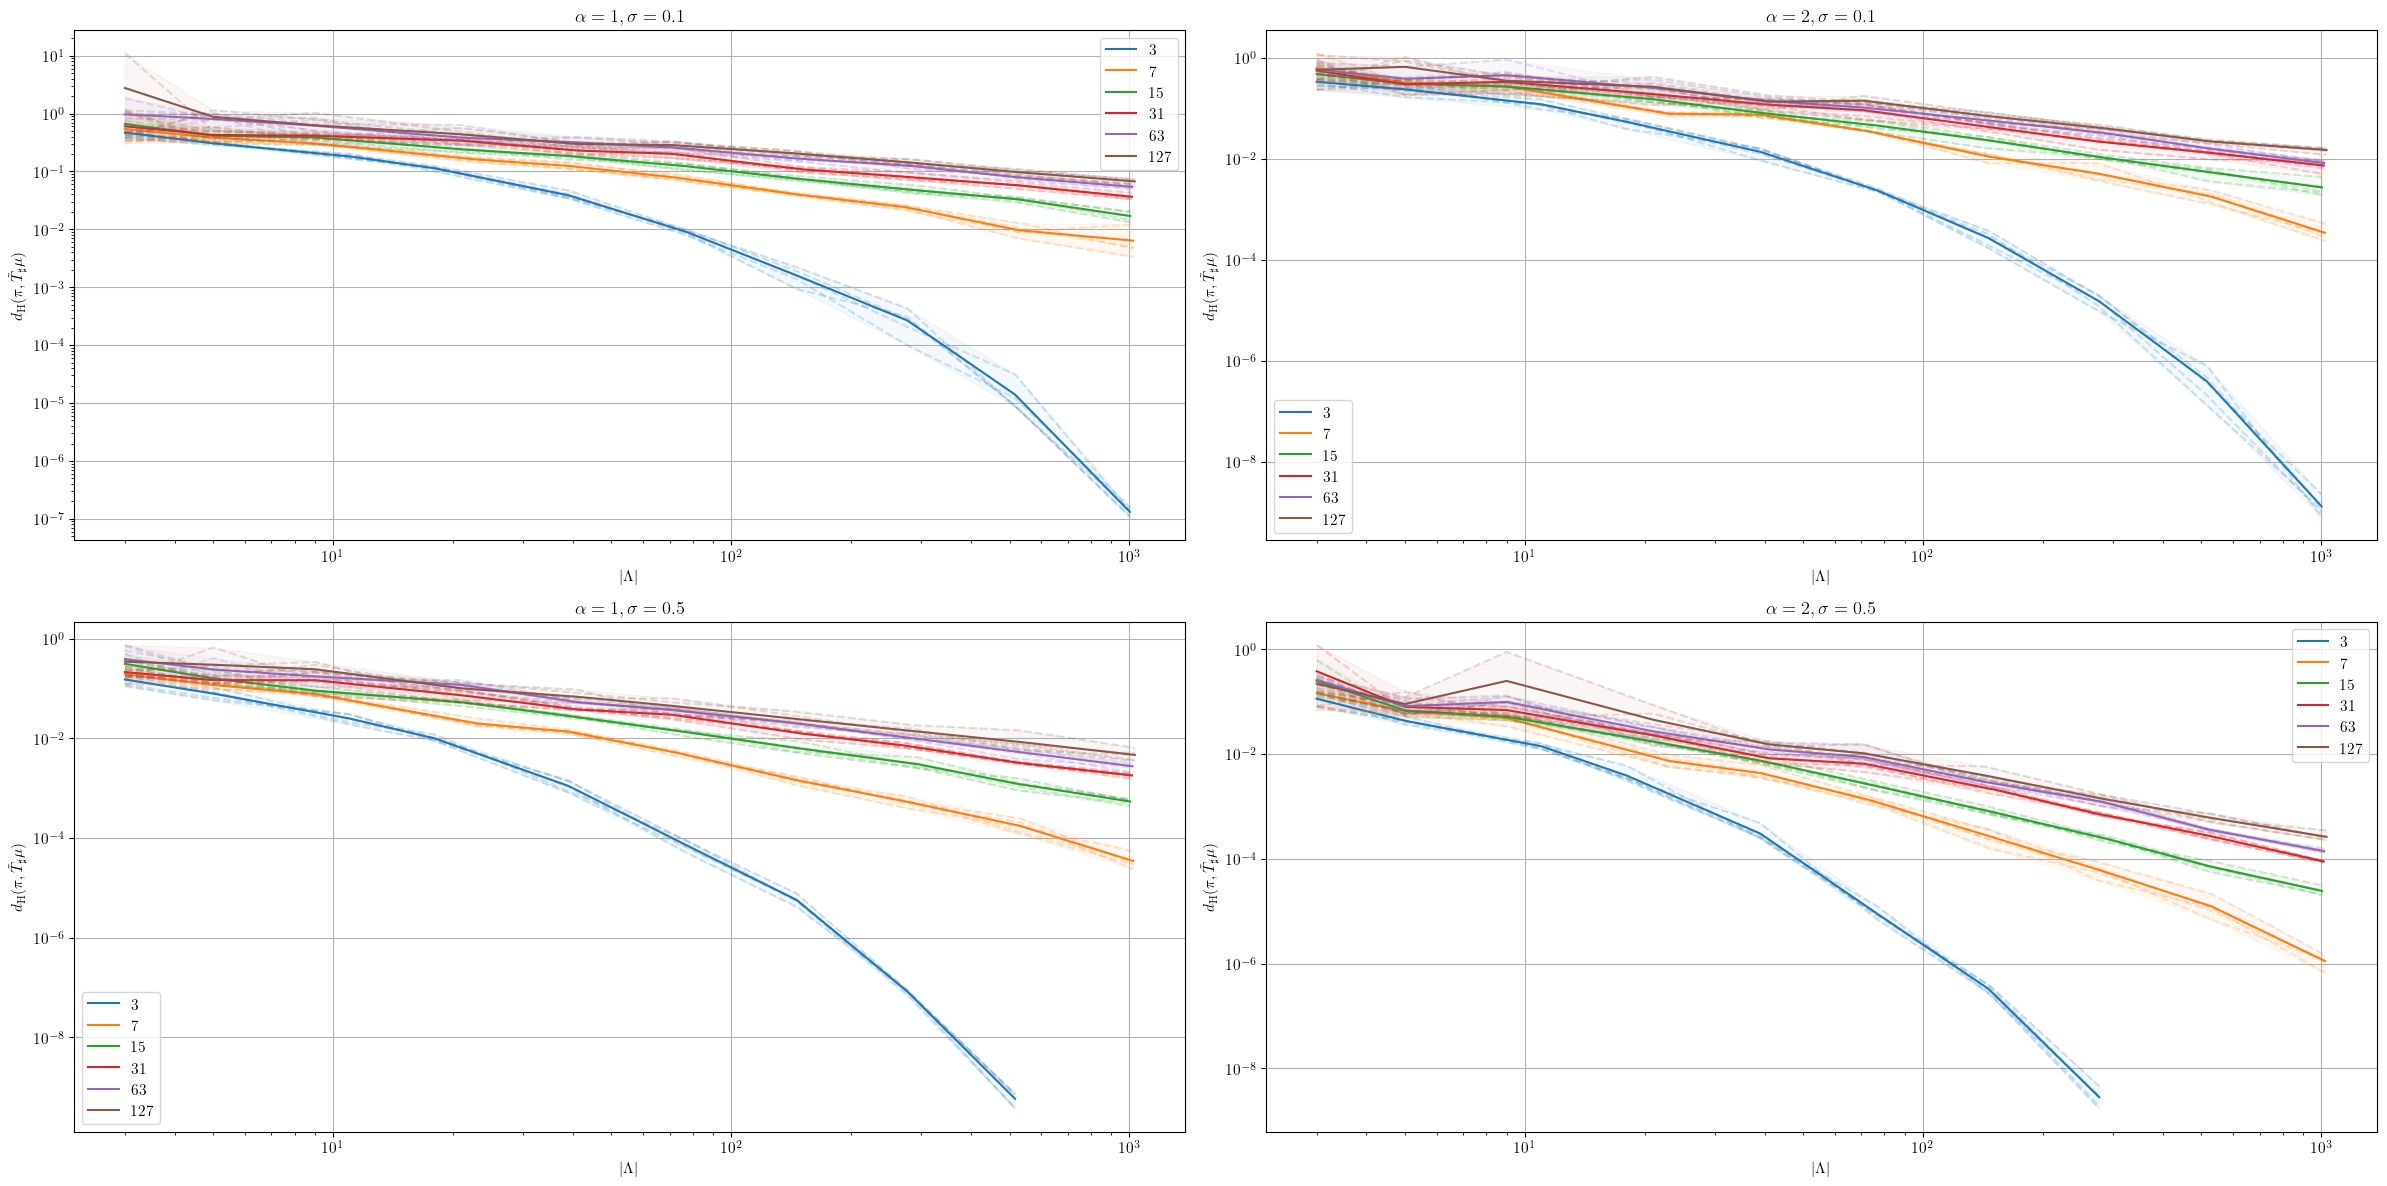

In [10]:
def plot_convergence(*, alphas=[1,2], noises=[.1,.5], verbose=False) :
    fig = plt.figure(figsize=(12*len(alphas), 6.*len(noises)))
    for i, alpha in enumerate(alphas) :
        for j, noise in enumerate(noises) :
            plot_convolution_hedist_convergence_single(alpha=alpha, noise=noise, fig=fig, nx=len(alphas), ny=len(noises), idx=i+1+j*len(alphas), 
                                                       title=r'$\alpha = {}, \sigma = {}$'.format(alpha, noise))
    plt.tight_layout()
    
plot_convergence()